# Canada Post - Data Scientist Candidate Case Study

## Business Context:
In late 2018, the Canadian Union of Postal Workers (CUPW) went on strike. Unfortunately, the strike fell during the busiest time of year for Canada Post, referred to as “Peak Season”.  The strike affected Canada Post’s profitability and fractured relationships with some of our customers – businesses who rely on Canada Post to deliver their products. 
There are two reasons for the effects on Canada Post’s profitability: 1) Canada Post was not able to operate at full capacity and 2) some customers took some or all of their business elsewhere (e.g. FedEx or UPS).

The marketing department has data on parcel volumes for the previous and current years, and would like to understand the impact on Canada Post’s volumes across the three customer groups: small, medium and large customers.

### Objective
**Business Question: What was the impact on Canada Post's volumes? How does it compare to prior years and how does it affect the customer groups?**

**Procedure**: 
1. Inspected the data
2. Cleaned, Transformed and Manipulated the data in order to perform analyses
3. Provided Descriptive Statistics such as ranges, averages, medians, top customers, bottom customers
4. Provided Visualizations such as a time series plot of the volume throughout all years and comparing the volume between years, the distributions of the data per year.
5. Compared proportions of customer groups
6. Found which customers had left throughout the years
7. Inspected the important dates
8. Performed Time Series Analysis and Forecasting



## Imports

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels
import scipy
import statsmodels.api as sm
import datetime
import itertools
import warnings
from pylab import rcParams
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
warnings.filterwarnings("ignore")
from fbprophet import Prophet
from tabulate import tabulate
%matplotlib inline

## Helper Functions

In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    """this is a function for allowing pandas dataframes to be displayed side-by-side on the same line like a table."""
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Load Data

In [3]:
df = pd.ExcelFile('Canada_Post_Customer_Data_revised.xlsx')
#inspect the sheets in the excel file and find how many and what the names are
df.sheet_names

['2019', '2018', '2017']

In [4]:
df_2019 = pd.read_excel('Canada_Post_Customer_Data_revised.xlsx', sheet_name='2019')
df_2018 = pd.read_excel('Canada_Post_Customer_Data_revised.xlsx', sheet_name='2018')
df_2017 = pd.read_excel('Canada_Post_Customer_Data_revised.xlsx', sheet_name='2017')

In [5]:
#look into the excel sheets
print(df_2017.head())
print(df_2018.head())
print(df_2019.head())

   Year  Week Number  cawdrey  microhm  candler  citizen  fordone  lighter  \
0  2017            1     1067    10695        0       28    15474    10735   
1  2017            2     2090    14565       43       32    14150     8188   
2  2017            3      965    14913       20       25    11684     9862   
3  2017            4     1299    13806       18       10    10954     5834   
4  2017            5     1508    14040       39       21    10295     5387   

   birling  capelin  ...  dacryon  gonadal  rending  toadied  seattle  \
0       84      107  ...     6082       10       17     7426     8494   
1       62      102  ...    14027       15       24    14605     7813   
2       88      103  ...     9392       28       75     8635    11536   
3      131       87  ...    13031       31       15     5849     7357   
4      338       62  ...    11934       17       23     8456     7276   

   protege  drawbar  swaddle  overlay  sullage  
0       23    13655       17    97817      

Looks like the the 2017 and 2018 have the same format however the 2019 sheet needs to be grouped and reshaped (pivoted).

In [6]:
#check dimensions of each year's data
print('The dimensions of the 2019 set: ',df_2019.shape)
print('The dimensions of the 2018 set: ',df_2018.shape)
print('The dimensions of the 2017 set: ',df_2017.shape)

The dimensions of the 2019 set:  (1540, 3)
The dimensions of the 2018 set:  (52, 104)
The dimensions of the 2017 set:  (53, 104)


The 2018 dataframe has 52 rows each being a week of the year. 2017 has an extra row that will need to be fixed. The 2019 dataframe needs to be pivoted to conform to the same format as the others. There are only 17 weeks of data in the 2019 dataframe.

## Data Preprocessing

In [7]:
#pivot the dataframe and aggregate volume by customer
df_2019 = df_2019.pivot_table(columns='Customer', index='Week_Number', values='Volume',aggfunc=np.sum)
df_2019 = df_2019.reset_index()

In [8]:
df_2019.columns.name = None
pd.options.display.float_format = '{:.0f}'.format
df_2019['Year'] = df_2019['Year'].astype(int)
df_2019 = df_2019.rename(columns={'Week_Number':'Week Number'})
df_2019

,Week Number,Year,agulhas,airline,allover,amenity,anchovy,angrier,aplitic,arecibo,...,subhead,sullage,supreme,toadied,triduum,tripoli,trismus,twinned,vistula,woodser
0,1,2019,71,nan,407,14,146,44,66,53,...,416,nan,nan,1134,49620,nan,20,181,6,3468
1,2,2019,123,18,818,39,2,204,109,67,...,480,14,nan,4444,51730,1,31,88,298,4242
2,3,2019,158,8,483,56,277,307,71,81,...,409,nan,nan,2762,49387,nan,70,111,313,3279
3,4,2019,107,nan,899,13,120,140,88,21,...,525,374,12,2213,45851,nan,26,79,342,2727
4,5,2019,129,nan,592,27,40,36,30,52,...,536,482,25,2419,38570,15,nan,57,91,2270
5,6,2019,162,15,446,21,85,172,111,41,...,459,196,37,5377,43957,nan,nan,nan,60,2454
6,7,2019,138,43,712,60,71,204,40,nan,...,417,260,7,2463,42171,22,2,69,220,2281
7,8,2019,106,39,747,39,103,165,89,20,...,468,109,37,2398,35528,53,nan,nan,134,1912
8,9,2019,168,23,604,nan,30,168,35,nan,...,446,89,37,2945,42111,73,nan,156,213,1808
9,10,2019,90,25,694,36,186,159,105,28,...,437,62,12,4184,39255,nan,14,64,273,1923


Need to impute nan with 0

In [9]:
df_2019 = df_2019.fillna(0)

In [10]:
df_2017 = df_2017.reindex(sorted(df_2017.columns), axis=1)
df_2017

,Week Number,Year,agulhas,airline,allover,amenity,anchovy,angrier,aplitic,arecibo,...,supreme,swaddle,taboret,toadied,triduum,tripoli,trismus,twinned,vistula,woodser
0,1,2017,83,11,365,21,74,163,38,18,...,0,17,526,7426,72201,0,10,185,155,2910
1,2,2017,98,13,246,16,105,210,126,33,...,50,31,348,14605,60960,0,27,69,75,2364
2,3,2017,57,35,374,18,44,163,149,48,...,1,12,235,8635,62057,0,53,94,205,2346
3,4,2017,127,30,367,0,30,208,76,31,...,63,57,249,5849,57184,16,50,83,274,1795
4,5,2017,121,32,424,24,26,146,132,5,...,57,0,308,8456,46156,8,0,107,285,1987
5,6,2017,113,6,401,0,47,174,92,59,...,0,30,335,12020,48261,0,0,82,197,1617
6,7,2017,93,8,324,38,69,75,47,57,...,49,9,355,12156,58865,83,0,72,175,1373
7,8,2017,116,7,360,6,66,129,34,22,...,36,9,460,8122,47741,46,58,147,137,1180
8,9,2017,125,3,312,48,99,221,174,0,...,56,26,456,11797,47994,0,14,152,324,1411
9,10,2017,106,28,324,62,84,234,144,32,...,0,33,447,18042,51124,35,25,169,357,1154


In [11]:
df_2018 = df_2018.reindex(sorted(df_2018.columns), axis=1)
df_2018

,Week Number,Year,agulhas,airline,allover,amenity,anchovy,angrier,aplitic,arecibo,...,supreme,swaddle,taboret,toadied,triduum,tripoli,trismus,twinned,vistula,woodser
0,1,2018,87,41,389,8,67,37,140,15,...,102,0,593,5297,94922,24,9,149,3,2876
1,2,2018,151,0,304,20,215,370,101,30,...,0,0,216,8576,71573,23,16,47,148,3300
2,3,2018,128,51,561,25,212,150,38,39,...,55,0,305,8332,68613,24,10,94,288,3251
3,4,2018,122,17,491,29,138,158,84,0,...,0,0,236,3728,74262,0,49,85,287,2690
4,5,2018,107,29,479,14,161,104,141,49,...,0,0,228,4748,58612,0,0,107,107,2474
5,6,2018,145,1,416,8,86,166,119,0,...,30,0,223,8404,64999,14,0,71,127,2595
6,7,2018,121,9,475,117,95,155,107,16,...,0,0,234,4613,61179,23,32,100,183,2034
7,8,2018,102,0,494,31,27,150,123,28,...,63,0,207,5082,63994,14,2,100,169,1858
8,9,2018,171,5,506,36,140,130,129,48,...,72,0,324,5053,54858,0,0,116,5,1949
9,10,2018,106,2,486,61,84,217,88,61,...,0,0,332,9485,60240,49,81,69,0,1550


The last row is the first week of the 2018 year and it has identical values so we can delete it

In [12]:
#discard the last row
df_2017 = df_2017[:-1]

Now we need to stack the dataframes together to get one combined dataframe.

In [13]:
#concatenating all years together
df = pd.concat([df_2019,df_2018,df_2017])

In [14]:
#impute 0 instead of na
df = df.fillna(0)

## Exploratory Data Analysis & Visualizations

In [171]:
# to visualize the data we need to make the data compact (similar to the 2019 dataframe)
df_stack = df.set_index(['Week Number','Year']).stack().reset_index(name='Volume').rename(columns={'level_2':'Customer'})
df_stack

,Week Number,Year,Customer,Volume
0,1,2019,agulhas,71.0000
1,1,2019,airline,0.0000
2,1,2019,allover,407.0000
3,1,2019,amenity,14.0000
4,1,2019,anchovy,146.0000
...,...,...,...,...
12458,52,2017,flunkou,3053.0000
12459,52,2017,mitford,26.0000
12460,52,2017,solubly,797.0000
12461,52,2017,swaddle,0.0000


In [172]:
#obtaining the top 10 customers for each year
top10_2017 = df_stack[df_stack['Year'] == 2017].groupby(by='Customer').sum()['Volume'].sort_values(ascending=False)[0:10]
top10_2017 = pd.DataFrame(top10_2017)
top10_2018 = df_stack[df_stack['Year'] == 2018].groupby(by='Customer').sum()['Volume'].sort_values(ascending=False)[0:10]
top10_2018 = pd.DataFrame(top10_2018)
top10_2019 = df_stack[df_stack['Year'] == 2019].groupby(by='Customer').sum()['Volume'].sort_values(ascending=False)[0:10]
top10_2019 = pd.DataFrame(top10_2019)
display_side_by_side(top10_2017,top10_2018,top10_2019)

,Volume
Customer,
flunkey,28323154.0000
neuston,5864925.0000
nonplus,5623575.0000
triduum,3426607.0000
overlay,3025408.0000
grafton,2825774.0000
lighter,1508086.0000
mitzvah,1453979.0000
hydroid,1411111.0000


These are the top 10 customers of 2017, 2018, 2019 respectively. Flunkey has the majority of the volume by far. Most of the customers are the same with slight differences in order.

In [173]:
#obtaining the last 10 customers for each year
last10_2017 = df_stack[df_stack['Year'] == 2017].groupby(by='Customer').sum()['Volume'].sort_values(ascending=True)[0:10]
last10_2017 = pd.DataFrame(last10_2017)
last10_2018 = df_stack[df_stack['Year'] == 2018].groupby(by='Customer').sum()['Volume'].sort_values(ascending=True)[0:10]
last10_2018 = pd.DataFrame(last10_2018)
last10_2019 = df_stack[df_stack['Year'] == 2019].groupby(by='Customer').sum()['Volume'].sort_values(ascending=True)[0:10]
last10_2019 = pd.DataFrame(last10_2019)
display_side_by_side(last10_2017,last10_2018,last10_2019)

,Volume
Customer,
flunkey_0001,0.0000
swaddle,1073.0000
trismus,1148.0000
airline,1246.0000
engager,1296.0000
amenity,1338.0000
puccoon,1349.0000
gossipy,1421.0000
ivylike,1433.0000


These are the last 10 customers of 2017, 2018, 2019 respectively. flunkey_0001 and flunkou could be subsidiaries of flunkey. Wherever there is a 0 means that the customer exists in one of the years but not where it was 0. For example, flunkey_0001 is absent in 2017, and 2018 but present in 2019, likewise, coaxial is absent in 2018, and 2019 but present in 2017. 

* The customers that were lost in 2018 (present in 2017 but absent in 2018): coaxial, swaddle
* The customers that were lost in 2019 (including the ones already lost from 2017-2018): coaxial, swaddle, taboret, mitford, flunkou, solubly
* Of all these lost customers, 3 of them are in the medium customer group and 3 are in the small customer group. None are from the large customer group
* The customer gained in 2019: flunkey_0001 (could be a subsidiary of flunkey)

In [174]:
# convert the week number and year as a datetime
df_stack['Year'] = df_stack['Year']
df_stack['Week Number'] = df_stack['Week Number']
df_stack['Time'] = df_stack['Year'].astype(str) + '-' + df_stack['Week Number'].astype(str)
df_stack['Time'] = df_stack['Time'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-%W-%w").date())

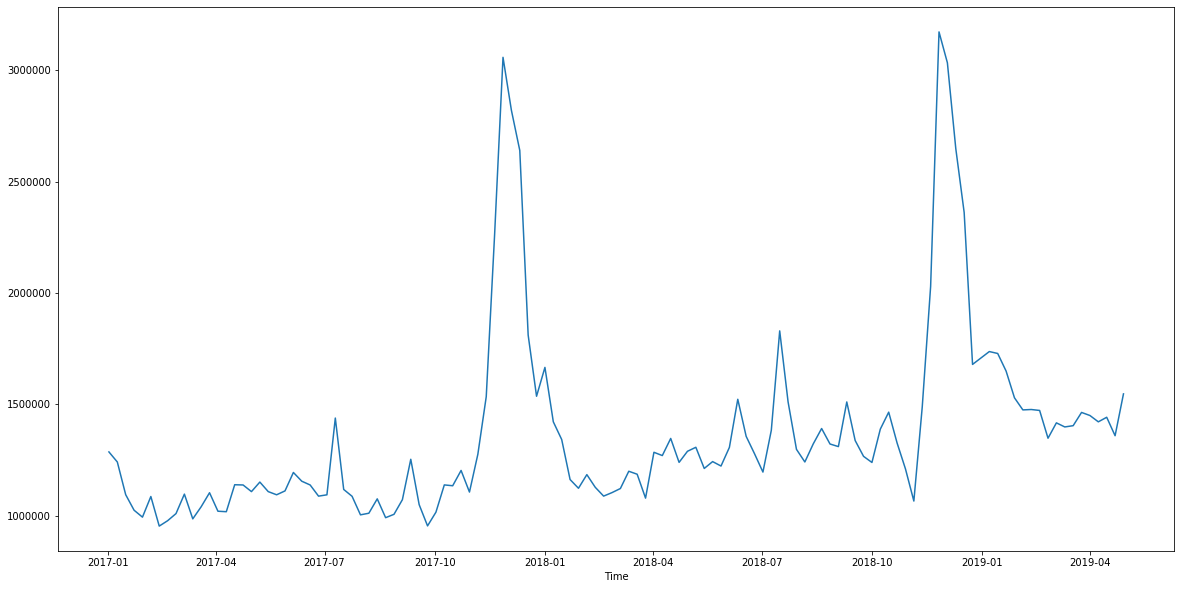

In [19]:
plt.figure(figsize=(20,10))
df_stack.groupby(['Time']).sum()['Volume'].plot()
plt.show()

This is a plot of the volume per week number ranging from 1 (which is the first week of 2017) to 121 (which is the 17th week of 2019). In this plot we can see peak seasons such as the end of 2017, a short-lived spike around the 80th week (which is around July 10 2018) and the largest peak at the end of 2018 and start of 2019 (starting from the 3rd week of November). There is also a short dip between the 95th week and the 98th week (this is around the week of October 22nd when the rotating strikes began)

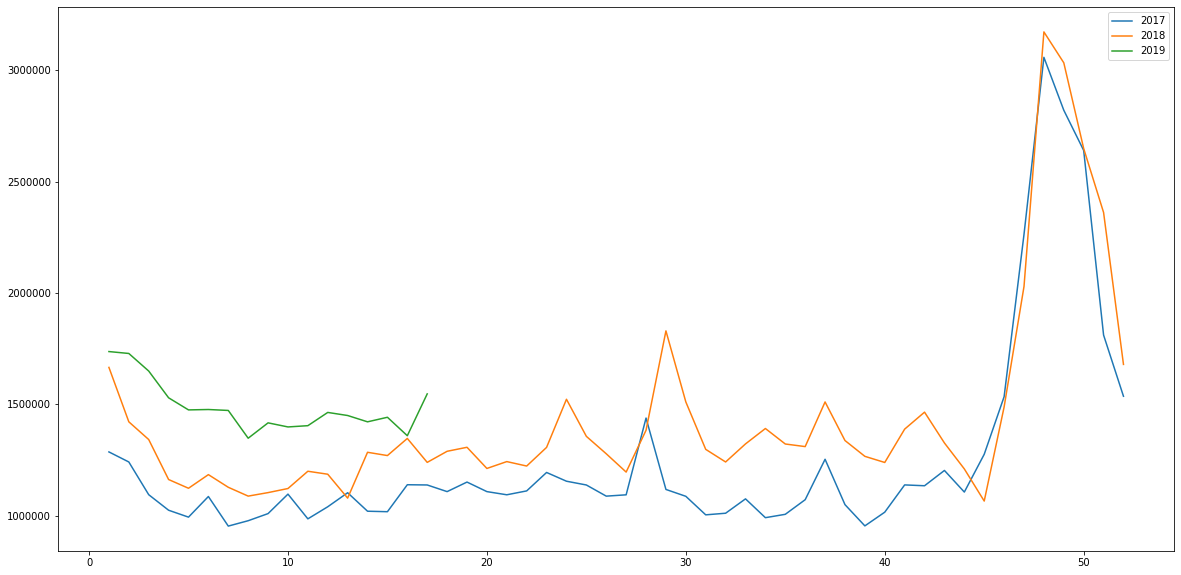

In [20]:
plt.figure(figsize=(20,10))
y = df_stack.groupby(['Time','Year','Week Number']).sum().reset_index()
plt.plot(y[y['Year'] == 2017][['Week Number']],y[y['Year'] == 2017][['Volume']])
plt.plot(y[y['Year'] == 2018][['Week Number']],y[y['Year'] == 2018][['Volume']])
plt.plot(y[y['Year'] == 2019][['Week Number']],y[y['Year'] == 2019][['Volume']])
plt.legend([2017,2018,2019])
plt.show()

When plotting year over year, we can see there is an increase in volume per year. There is a brief dip in 2018 before the dip when the strike was occuring. Also note that the pattern is very similar year by year which shows that the seasonality is systematic with an increasing yearly trend. Almost all of the volume in 2018 is greater than the prior year's volume except around the time of the strike. This suggests that the strike may have affected the volume of 2018. Also since 2019's volume is greater than the prior years' volume we can assume that Canada Post has recovered from the strike and was able to maintain the yearly upward trend.

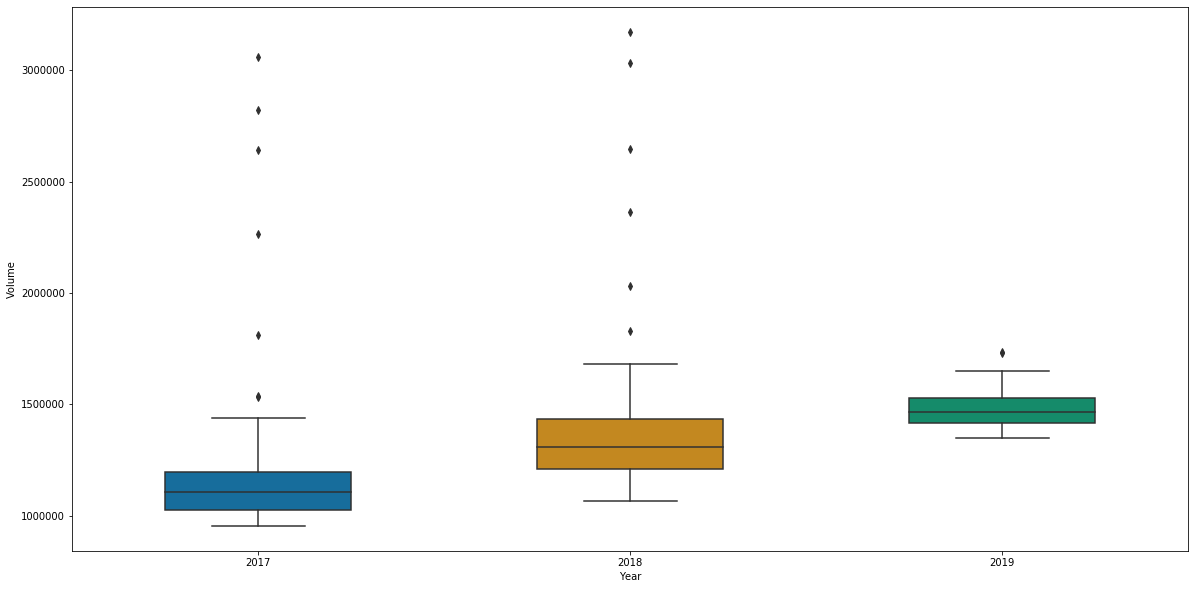

In [21]:
plt.figure(figsize=(20,10))
sns.boxplot(y='Volume', x='Year',
                 data=y, 
                 width=0.5,
                 palette="colorblind")
plt.show()

This is a box plot of the volume per year. We can see that the median increases per year suggesting an upward trend. The points are outliers. This shows that there are an equal number of outliers in 2017 and 2018 which can be from the weeks of the peak season. 2019 does not have as many outliers because there are 17 weeks of data as opposed to 52.

In [22]:
stats_2017 = pd.DataFrame(df_stack[df_stack['Year'] == 2017].groupby(by='Customer').sum()['Volume'].describe())
stats_2018 = pd.DataFrame(df_stack[df_stack['Year'] == 2018].groupby(by='Customer').sum()['Volume'].describe())
stats_2019 = pd.DataFrame(df_stack[df_stack['Year'] == 2019].groupby(by='Customer').sum()['Volume'].describe())
stats_allyrs = pd.DataFrame(df_stack.groupby(by='Customer').sum()['Volume'].describe())
display_side_by_side(stats_2017,stats_2018,stats_2019,stats_allyrs)

,Volume
count,103
mean,631374
std,2919857
min,0
25%,2450
50%,10863
75%,117742
max,28323154
,Volume
count,103


            2017               2018             2019             Overall

If we group the data by the customer and sum the volume of each customer, the average volume is 1,602,364. The average volume of 2017 is 631,374, the average volume of 2018 is 725,219, and the average volume of 2019 is 245,771. The average volume increased from 2017 to 2018 but decreased in 2019, however this is due to the fact that there were only 17 weeks available for the 2019 year.

### Customer Groups:
* Small – Less than 10,000 parcels per year
* Medium – 10,000 to 500,000 parcels per year
* Large – Over 500,000 parcels per year

In [23]:
# categorize customers into groups; small, medium, large
df_custgroup = df_stack.groupby(['Year', 'Customer']).sum()
df_custgroup['Customer Group'] = None
df_custgroup.loc[df_custgroup['Volume'] <= 10000, 'Customer Group'] = 'Small'
df_custgroup.loc[(df_custgroup['Volume'] > 10000) & (df_custgroup['Volume'] <= 500000), 'Customer Group'] = 'Medium'
df_custgroup.loc[df_custgroup['Volume'] > 500000, 'Customer Group'] = 'Large'

In [24]:
df_custgroup.reset_index(inplace=True) 
pd.options.display.float_format = '{:.4f}'.format

,Customer Group
Small,0.4466
Medium,0.3107
Large,0.2427
,Customer Group
Small,0.4854
Medium,0.3010
Large,0.2136
,Customer Group
Small,0.6602
Medium,0.2913


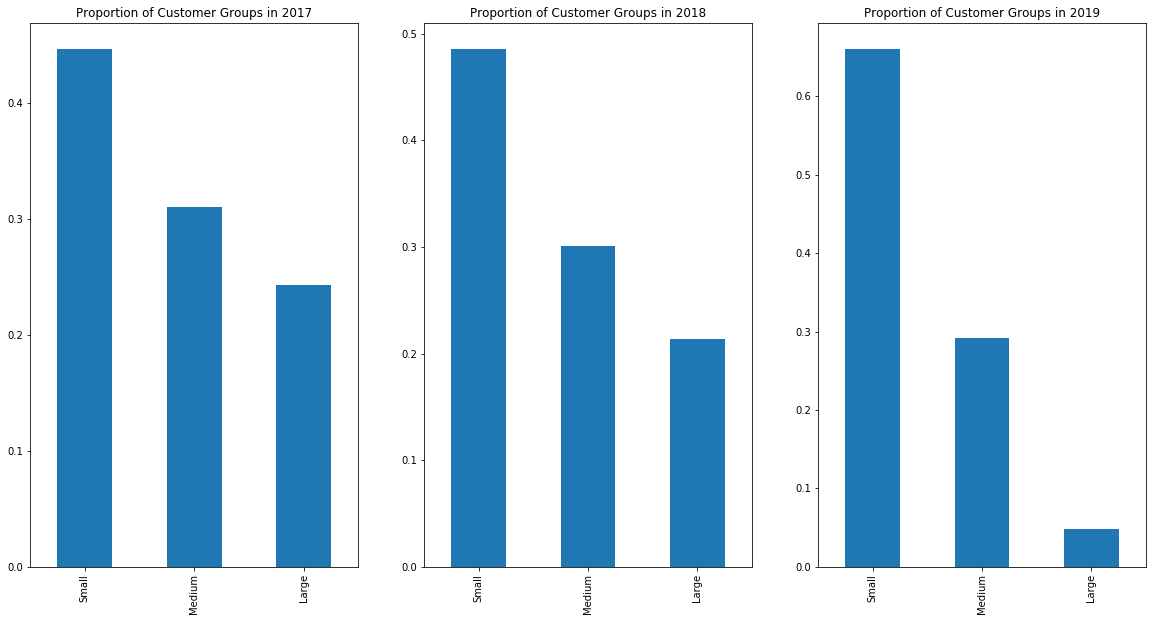

In [25]:
sml_2017 = pd.DataFrame(df_custgroup[df_custgroup['Year'] == 2017]['Customer Group'].value_counts(normalize=True))
sml_2018 = pd.DataFrame(df_custgroup[df_custgroup['Year'] == 2018]['Customer Group'].value_counts(normalize=True))
sml_2019 = pd.DataFrame(df_custgroup[df_custgroup['Year'] == 2019]['Customer Group'].value_counts(normalize=True))
display_side_by_side(sml_2017,sml_2018,sml_2019)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 10))
ax1 = df_custgroup[df_custgroup['Year'] == 2017]['Customer Group'].value_counts(normalize=True).plot.bar(ax=axes[0])
ax2 = df_custgroup[df_custgroup['Year'] == 2018]['Customer Group'].value_counts(normalize=True).plot.bar(ax=axes[1])
ax3 = df_custgroup[df_custgroup['Year'] == 2019]['Customer Group'].value_counts(normalize=True).plot.bar(ax=axes[2])
ax1.title.set_text('Proportion of Customer Groups in 2017')
ax2.title.set_text('Proportion of Customer Groups in 2018')
ax3.title.set_text('Proportion of Customer Groups in 2019')
plt.show()

We can see that the proportion of large customers decreases slightly from 2017 to 2018 and then substantially in 2019, from 20%-25% to less than 5% in 2019. We can perform a hypothesis test to show that the proportions are statistically different. We can also see that the small customers hold the majority of the volume for all years and each year has a descending order of volume from small customers to large customers. However, the reason that the proportion of large customers is very little in 2019 is because the data only had 17 weeks out of 52 and therefore the number of customers with over 500,000 parcels within only 17 of the 52 weeks is substantially smaller. As a proxy, we can try to compare the first 17 weeks of each year.

In [26]:
# take a subset of the first 17 weeks per year
weeks = list(range(1,18)) + list(range(53,70)) + list(range(105,121))
weeks
df_17wks = df_stack.loc[df_stack['Week Number'].isin(weeks)]
df_custgroup_17wks = df_17wks.groupby(['Customer','Year']).sum()
df_custgroup_17wks = df_custgroup_17wks.drop(columns = 'Week Number')
# categorize customers into groups; small, medium, large
df_custgroup_17wks['Customer Group'] = None
df_custgroup_17wks.loc[df_custgroup_17wks['Volume'] <= 10000, 'Customer Group'] = 'Small'
df_custgroup_17wks.loc[(df_custgroup_17wks['Volume'] > 10000) & (df_custgroup_17wks['Volume'] <= 500000), 'Customer Group'] = 'Medium'
df_custgroup_17wks.loc[df_custgroup_17wks['Volume'] > 500000, 'Customer Group'] = 'Large'
df_custgroup_17wks.reset_index(inplace=True) 

,Customer Group
Small,70
Medium,27
Large,6
,Customer Group
Small,70
Medium,27
Large,6
,Customer Group
Small,68
Medium,30


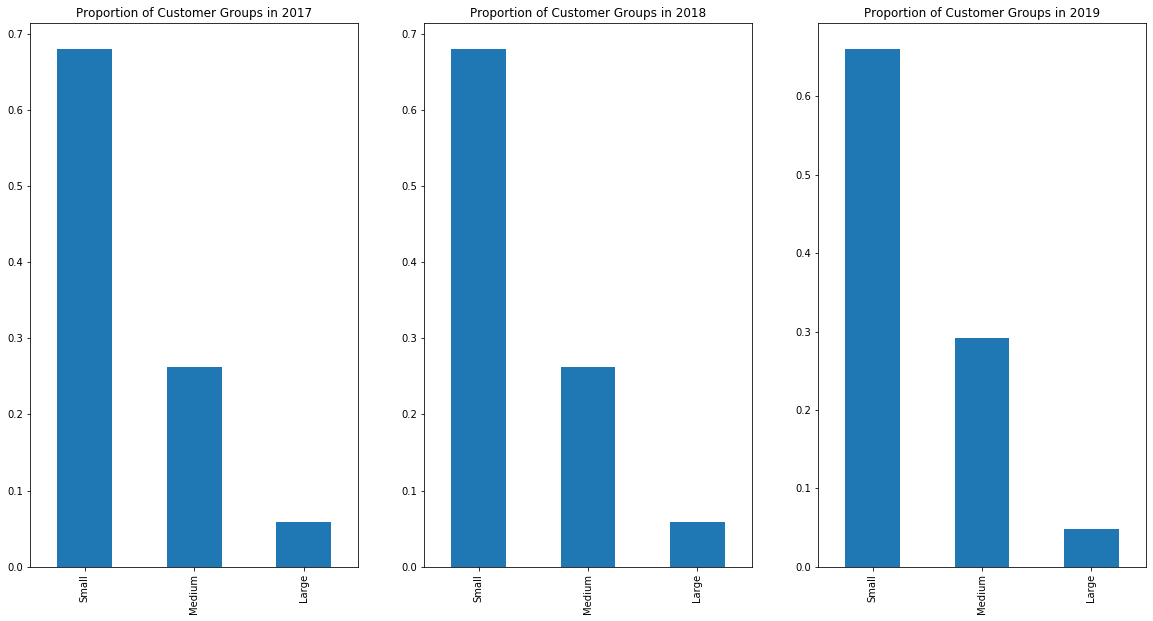

In [27]:
sml_2017 = pd.DataFrame(df_custgroup_17wks[df_custgroup_17wks['Year'] == 2017]['Customer Group'].value_counts())
sml_2018 = pd.DataFrame(df_custgroup_17wks[df_custgroup_17wks['Year'] == 2018]['Customer Group'].value_counts())
sml_2019 = pd.DataFrame(df_custgroup_17wks[df_custgroup_17wks['Year'] == 2019]['Customer Group'].value_counts())
display_side_by_side(sml_2017,sml_2018,sml_2019)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 10))
ax1 = df_custgroup_17wks[df_custgroup_17wks['Year'] == 2017]['Customer Group'].value_counts(normalize=True).plot.bar(ax=axes[0])
ax2 = df_custgroup_17wks[df_custgroup_17wks['Year'] == 2018]['Customer Group'].value_counts(normalize=True).plot.bar(ax=axes[1])
ax3 = df_custgroup_17wks[df_custgroup_17wks['Year'] == 2019]['Customer Group'].value_counts(normalize=True).plot.bar(ax=axes[2])
ax1.title.set_text('Proportion of Customer Groups in 2017')
ax2.title.set_text('Proportion of Customer Groups in 2018')
ax3.title.set_text('Proportion of Customer Groups in 2019')
plt.show()

Comparing the first 17 weeks of each year, we can see that the customer groupings for 2017 and 2018 are the same. There is a slight difference in the 2019 year where there is a higher proportion of medium customers (2 that were small customers and 1 that was large)

In [28]:
print('The volume of the first 17 weeks of 2017 was: ',df_stack[df_stack['Year'] == 2017].loc[df_stack['Week Number'].isin(range(1,18))]['Volume'].sum())
print('The volume of the first 17 weeks of 2018 was: ',df_stack[df_stack['Year'] == 2018].loc[df_stack['Week Number'].isin(range(1,18))]['Volume'].sum())
print('The volume of the first 17 weeks of 2019 was: ',df_stack[df_stack['Year'] == 2019].loc[df_stack['Week Number'].isin(range(1,18))]['Volume'].sum())

The volume of the first 17 weeks of 2017 was:  18202688.0
The volume of the first 17 weeks of 2018 was:  20941629.0
The volume of the first 17 weeks of 2019 was:  25314387.0


When we compare the total volume of the first 17 weeks per year, we see that it increases each year and the strike did not affect the volume compared to the prior year. This isn't to say that the volume was not impacted from the strike.

In [29]:
# we can also compare the last weeks to see the effect of the strike. Unfortunately you can only compare with 2017 since 2019 is not complete
print('The volume of the last 17 weeks of 2017 was: ',df_stack[df_stack['Year'] == 2017].loc[df_stack['Week Number'].isin(range(35,53))]['Volume'].sum())
print('The volume of the last 17 weeks of 2018 was: ',df_stack[df_stack['Year'] == 2018].loc[df_stack['Week Number'].isin(range(35,53))]['Volume'].sum())

The volume of the last 17 weeks of 2017 was:  27867663.0
The volume of the last 17 weeks of 2018 was:  30849518.0


When we compare the total volume of the last 17 weeks per year (excluding 2019), we see that it increases each year and the strike did not affect the volume compared to the prior year. This isn't to say that the volume was not impacted from the strike.

## Segmenting important dates

*	Peak Season 2017: Nov 20, 2017 to Jan 3, 2018
*	Peak Season 2018: November 5, 2018 to January 11, 2019
*	Potential for strike first appears in media: September 12, 2018
*	Union voted in favour of strike action: September 26, 2018
*	Rotating Strikes began: October 22, 2018 
*	Back to work legislation took effect: November 27th

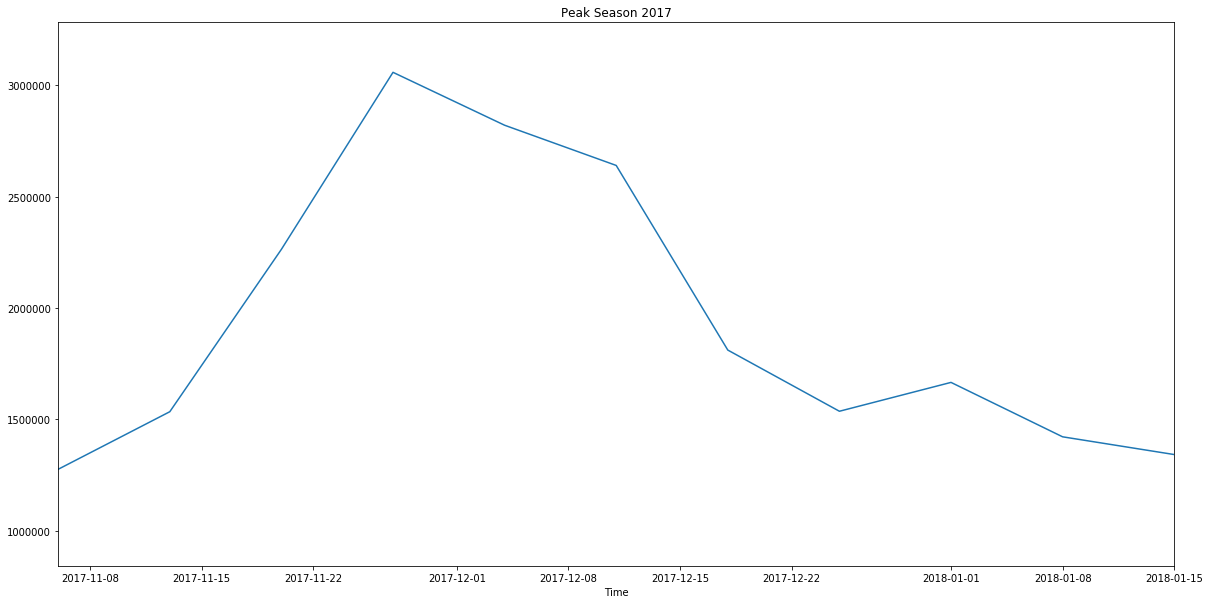

In [202]:
y = df_stack.groupby(['Time']).sum()['Volume']
plt.figure(figsize=(20,10))
y.plot()
plt.xlim([datetime.date(2017, 11, 6),datetime.date(2018, 1, 15)])
plt.title('Peak Season 2017')
plt.show()

This is a plot of the peak season of 2017 which is from Nov 20, 2017 to Jan 3, 2018. We can see that the volume starts to increase from the 8th of November and peaks around Nov 22nd - Dec 1st and starts declining.

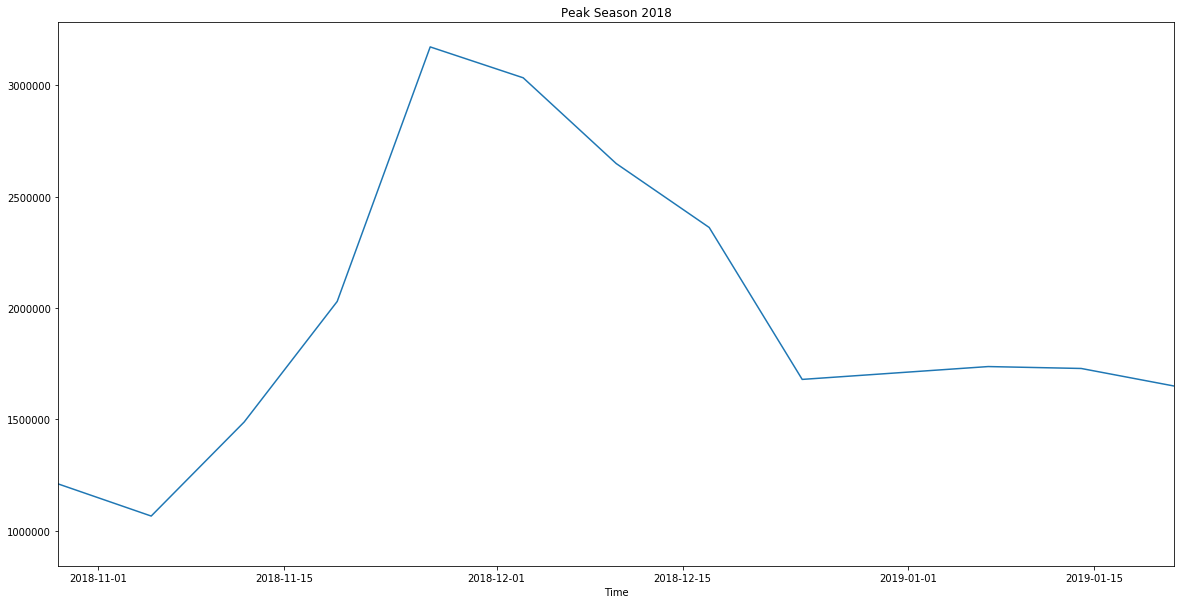

In [32]:
plt.figure(figsize=(20,10))
y.plot()
plt.xlim([datetime.date(2018, 10, 29),datetime.date(2019, 1, 21)])
plt.title('Peak Season 2018')
plt.show()

This is a plot of the peak season of 2018 which is from November 5, 2018 to January 11, 2019. The volume starts to increase after November 1st and peaks close to the beginning of December and then declines until the new year.

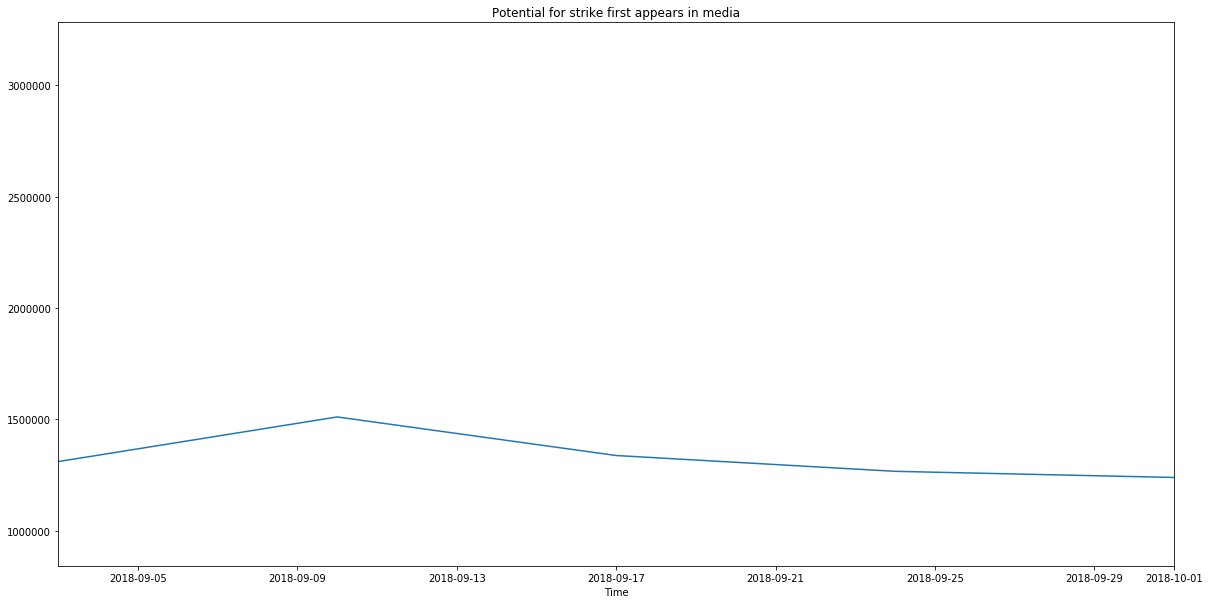

In [33]:
plt.figure(figsize=(20,10))
y.plot()
plt.xlim([datetime.date(2018, 9, 3),datetime.date(2018, 10, 1)])
plt.title('Potential for strike first appears in media')
plt.show()

This is a plot of the time around the potential for strike first appearing in media: September 12, 2018. There is a slight decrease around that time.

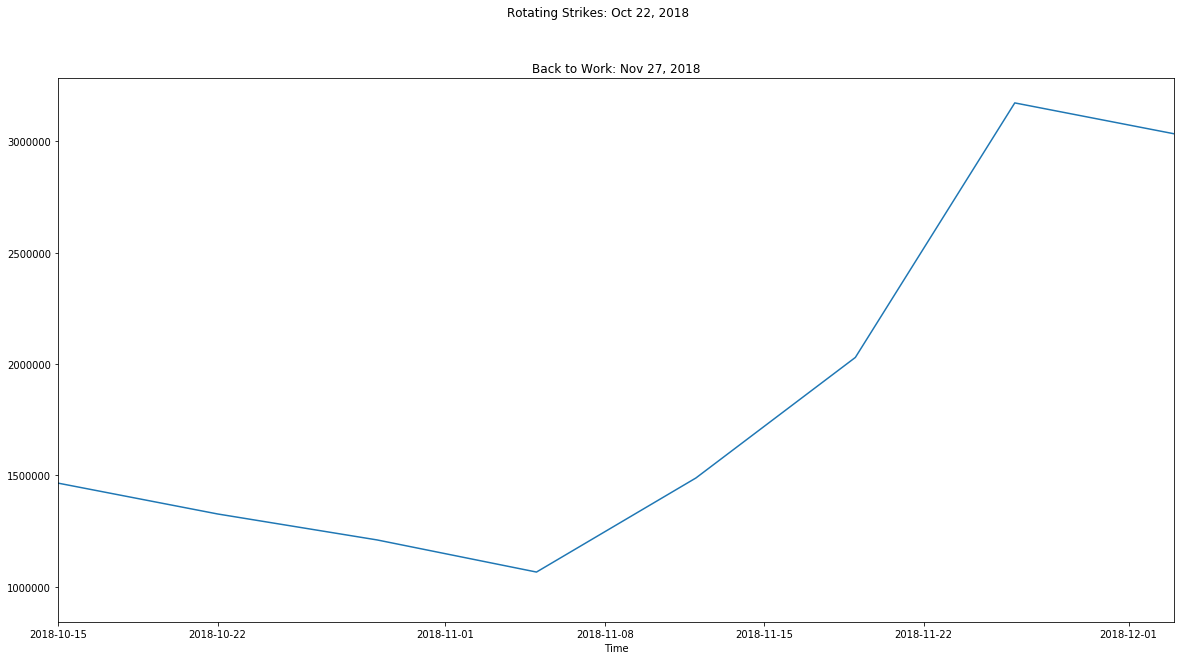

In [34]:
plt.figure(figsize=(20,10))
y.plot()
plt.xlim([datetime.date(2018, 10, 15),datetime.date(2018, 12, 3)])
plt.title('Back to Work: Nov 27, 2018')
plt.suptitle('Rotating Strikes: Oct 22, 2018')
plt.show()

This is a plot of the time around the rotating strikes and the back to work legislation. The rotating strikes started around Oct 22nd and that's where there is a decline and then it starts to increase around mid November and peaks around Nov 27th.

In [175]:
#add the customer group labels to the dataset
df_stack['Customer Group'] = None
for c,y,g in df_custgroup[['Customer','Year','Customer Group']].values:
    df_stack.loc[(df_stack['Customer'] == c) & (df_stack['Year'] == y), 'Customer Group'] = g

In [207]:
x = df_stack.groupby(['Time','Year','Week Number','Customer Group']).agg({'Customer':'count',  
                         'Volume':'sum'}).reset_index()
x = x.set_index('Time')

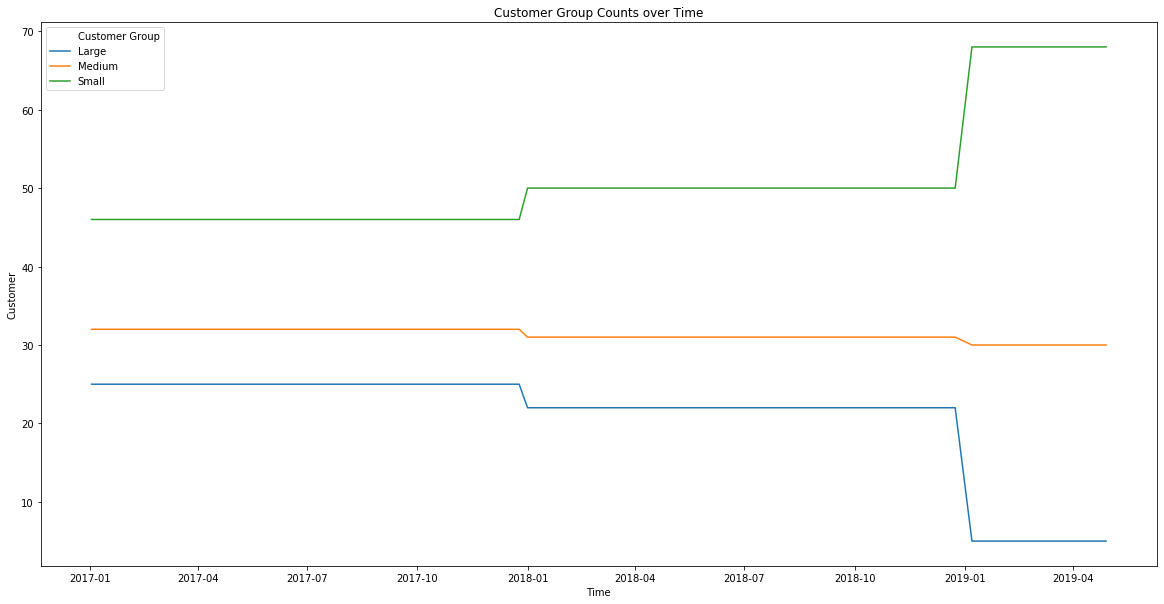

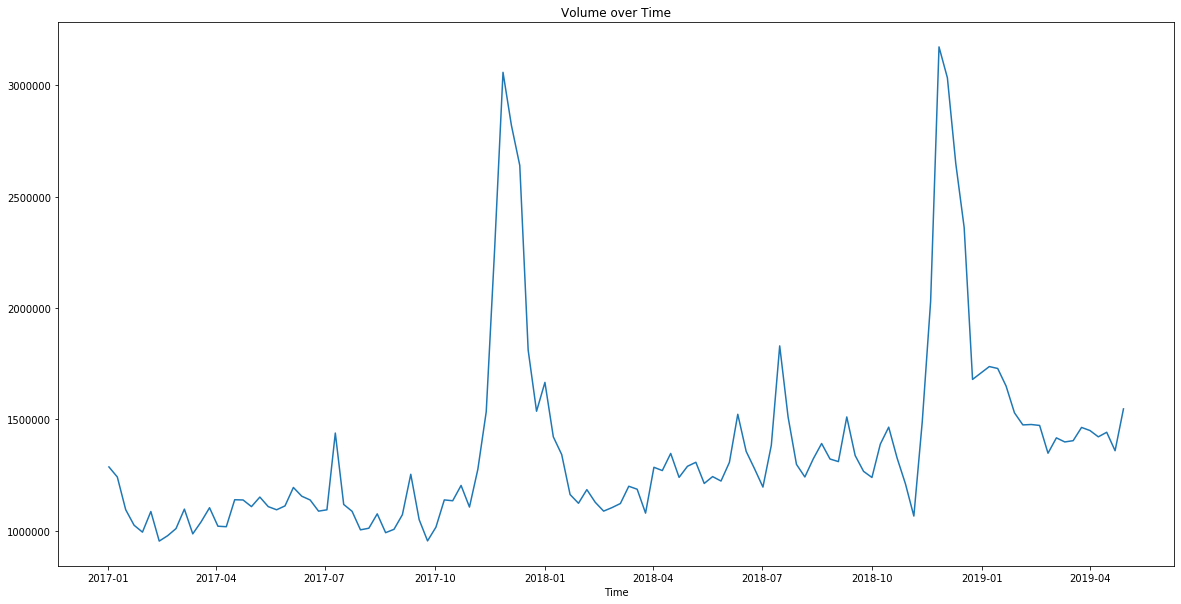

In [236]:
plt.figure(figsize=(20,10))
plt.title('Customer Group Counts over Time')
sns.lineplot(x=x.index, y = 'Customer', hue = 'Customer Group', data = x)
plt.show()
plt.figure(figsize=(20,10))
plt.title('Volume over Time')
y.plot()
plt.show()

The top plot shows the counts of the Customer Groups over time. We can see that the large customer group declines in the beginning of 2019 and the small customer group increases. The medium customer group stays fairly consistent.

## Time Series Analysis & Forecasting

Time series analysis accounts for the fact that data points taken over time may have an internal structure (such as autocorrelation, trend or seasonal variation) that should be accounted for.
Using this time-series data we can do some time series analysis and forecasting. We can forecast the future values of the 2019 year and we can also try to forecast 2018 as if the strike never happened and see what the difference is.

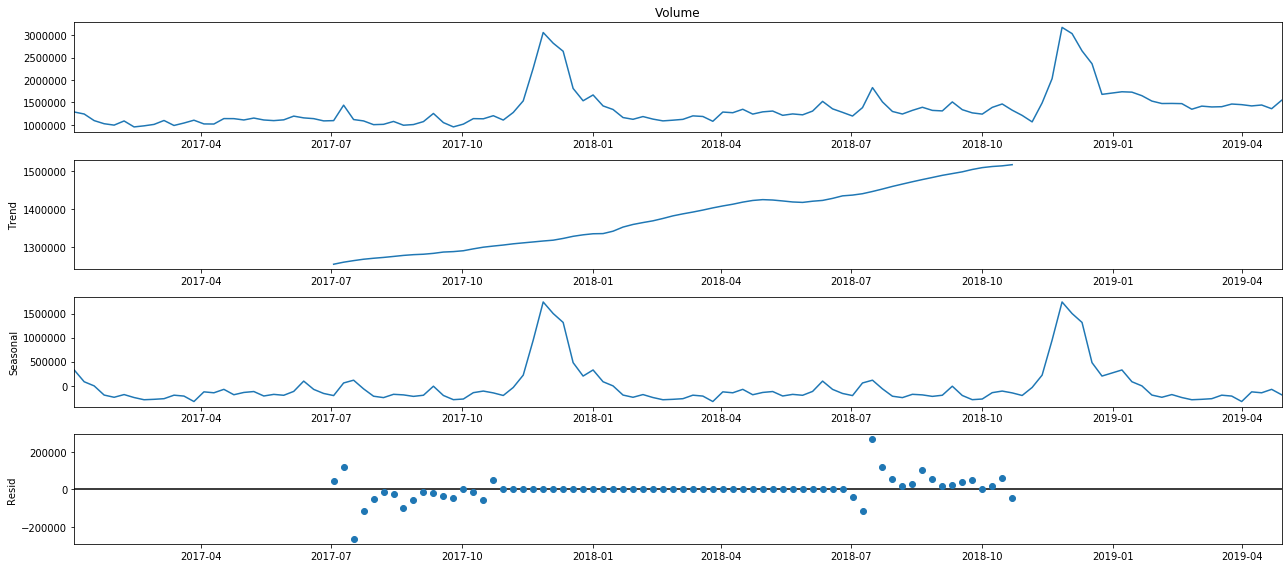

In [90]:
rcParams['figure.figsize'] = 18, 8
y = df_stack.groupby(['Time']).sum()['Volume']
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=52)
pd.plotting.register_matplotlib_converters()
fig = decomposition.plot()
plt.show()

This is to visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise. We can see that the trend is linearly increasing and the data has a seasonal pattern where there's a spike during peak season each year. The residuals show that it's fairly stable with some noise near the tails.
Note: the model we are using is an additive model not multiplicative since the trend is linear and the seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

In [86]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [87]:
aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            aic.append(param,param_seasonal,results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:3744.2794811700355
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:3327.7963525800583
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:3197.5369645497053
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2823.7192752426117
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:3224.337533853132
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:3177.4998482124884
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2840.556490118753
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2811.232829038593
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:642390.7756744018
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:3251.243330264468
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:3091.1248391065938
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:2734.381289369495
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:3302.5147920989207
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:3242.2223380270034
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:2788.2098352004314
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:2731.544993343669
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:3273.2900136064713
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:2956.9365085115146
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:

The above output suggests that ARIMA(0, 1, 1)x(1, 1, 1, 12)  yields the lowest AIC value of 2629.66. Therefore we should consider this to be optimal option.

In [84]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2923      0.135      2.173      0.030       0.029       0.556
ar.S.L12      -0.2585      0.253     -1.022      0.307      -0.754       0.237
ma.S.L12      -0.6170      0.144     -4.279      0.000      -0.900      -0.334
sigma2      1.103e+11   7.47e-13   1.48e+23      0.000     1.1e+11     1.1e+11


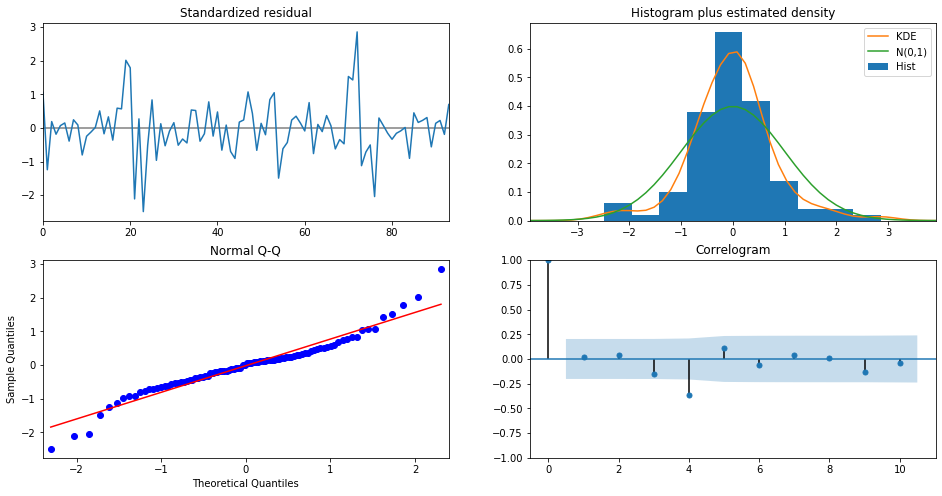

In [85]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

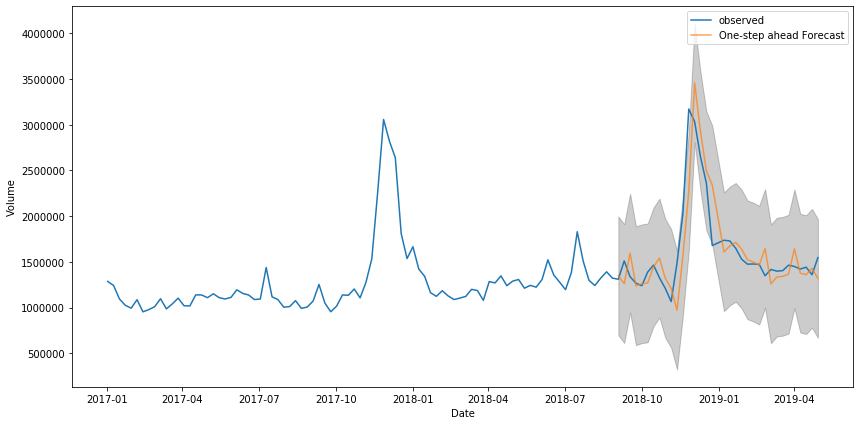

In [95]:
pred = results.get_prediction(start=datetime.date(2018, 9, 3), dynamic=False)
pred_ci = pred.conf_int()
ax = y[datetime.date(2017, 1, 2):].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()
plt.show()

Using our time series model to predict the 2018 volume around the time of the strike, we can see that it is very close to the actual values but with a higher peak (the shaded area is the confidence interval of the model).

In [83]:
y_forecasted = pred.predicted_mean
y_truth = y[datetime.date(2017, 1, 2)::]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 101659338532.88
The Root Mean Squared Error of our forecasts is 318840.62


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit. Our MSE is fairly high which means the model can be optimized better.
Root Mean Square Error (RMSE) tells us that our model was able to forecast the average volume in the test set within 318840.62 of the real volume.

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running and we can try to use it to better accomodate the data.

In [107]:
#create a separate dataframe for the peak seasons Nov 20, 2017 to Dec 3, 2018 & November 5, 2018 to January 11, 2019
#holidays
peak_2017 = y[datetime.date(2017, 11, 20):datetime.date(2018, 1, 8)].reset_index()
peak_2017['holiday'] = 'peak season'
peak_2018 = y[datetime.date(2018, 11, 5):datetime.date(2019, 1, 14)].reset_index()
peak_2018['holiday'] = 'peak season'
peaks = pd.concat([peak_2017,peak_2018], ignore_index=True).rename(columns={'Time':'ds'})
peaks = peaks.drop(columns=['Volume'])
peaks = peaks[['holiday','ds']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

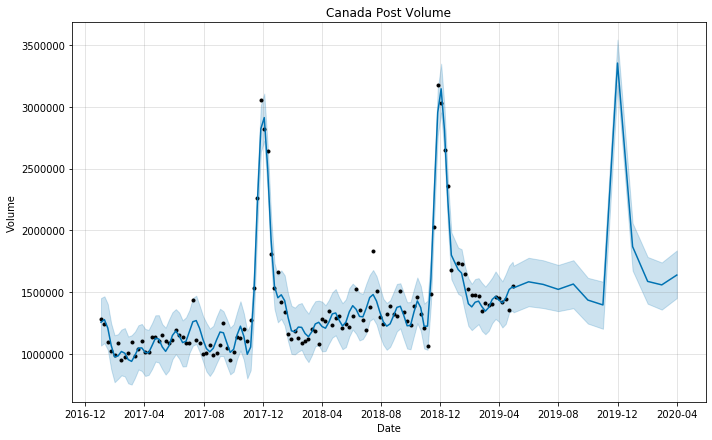

In [125]:
m = y.reset_index().rename(columns = {'Time': 'ds','Volume': 'y'})
#optional add parameter holidays=peaks
model = Prophet(interval_width=0.95,yearly_seasonality=True)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(m)
forecast = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(forecast)
plt.figure(figsize=(18, 6))
model.plot(forecast, xlabel = 'Date', ylabel = 'Volume')
plt.title('Canada Post Volume');

Using Prophet we were able to forecast the rest of the 2019 year and we can see that it is very similar to the prior years with an upward trend.

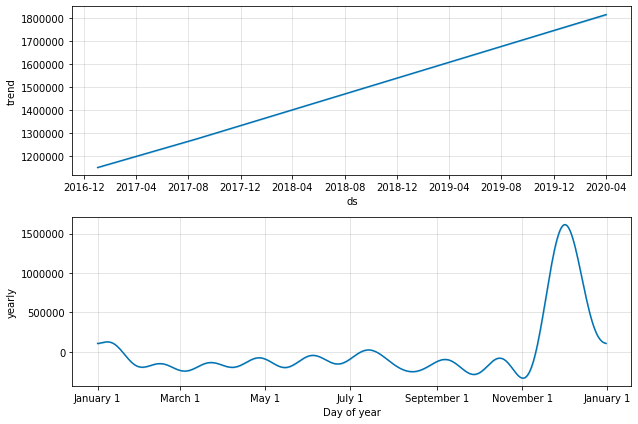

In [126]:
model.plot_components(forecast);

We see again that the trend is linear and the yearly seasonality stays relatively at the same level except when peak season comes.

## Conclusion

In this analysis we can see:
* The Year over Year trend is linearly increasing and the Canada Post strike did not affect the trend. The strike may have affected the magnitude of the peak season of 2018 but overall the trend stayed linear and the volume surpassed the prior year's volume.
* The customer groups proportions change slightly year over year and the proportions are approximately 45% small, 30% medium and 25% large.
* The customers that were lost are shown in the analysis
* A forecast of the 2019 year and also a forecast to show how 2018 might be without the strike
* The distributions of the yearly data
* Visualizations of the data along with important dates
* The most and least contributing customers
* The change of customer group compositions over time
